<a href="https://colab.research.google.com/github/bilgin-kocak/fenics-tutorials-anders-logg/blob/master/Exercise_5b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 5b: Application to Elasticity (nonlinear)
![image.png](attachment:image.png)

In this exercise, we will solve the equations of nonlinear elasticity (hyperelasticity) with FEniCS:

\begin{alignat}{2}
-\nabla\cdot P(u) &= f \quad && \text{in } \Omega \\
u &= u_{\mathrm{L}} \quad && \text{on } \Gamma_{\mathrm{L}} \\
u &= u_{\mathrm{R}} \quad && \text{on } \Gamma_{\mathrm{R}} \\
\sigma\cdot n &= g \quad && \text{on } \Gamma_{\mathrm{N}}
\end{alignat}

where $P = FS$ is the first Piola-Kirchoff stress tensor, $F$ is the deformation gradient and $S$ is the second Piola-Kirchoff stress tensor. We will use the Saint Venant-Kirchoff model expressed by the strain energy density

\begin{align}
W(E) = \frac{\lambda}{2}\,\mathrm{tr}(E)^2 + \mu\,\mathrm{tr}(E^2).
\end{align}

We will use the following data:

* $\Omega = (0,2)\times(0,1)\times(0,1)$
* $G = 79300\,\mathrm{[Pa]}$ (shear modulus)
* $K = 160000\,\mathrm{[Pa]}$ (bulk modulus)
* $f = (0,0,0)$
* $\Gamma_{\mathrm{L}} = \{(x,y,z) \in \partial\Omega \mid x = 0\}$ (the left boundary)
* $\Gamma_{\mathrm{R}} = \{(x,y,z) \in \partial\Omega \mid x = 2\}$ (the right boundary)
* $\Gamma_{\mathrm{N}} = \partial\Omega \setminus (\Gamma_{\mathrm{L}} \cup \Gamma_{\mathrm{R}})$
* $u_{\mathrm{L}} = (0,0,0)$ (fixed)
* $u_{\mathrm{R}} = (1, 0.5-y+(y-z)/\sqrt{2}, 0.5-z+(y+z-1)/\sqrt{2})$ (stretched and rotated)
* $g = (0,0,0)$

Compute the Lamé parameters $\mu$ and $\lambda$ from the shear modulus and bulk modulus. The given values are those of steel scaled down by a factor $10^6$.

## Importing FEniCS
The first thing we need to do is to import FEniCS.

In [ ]:
# Installing and Importing Fenics
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from fenics import *; from mshr import *
    
dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

## Initializing notebook plotting
When running in a Jupyter notebook, a special line is necessary to show FEniCS plots in the notebook.

In [ ]:
%matplotlib inline

## Creating the mesh
To create the mesh, use the `BoxMesh` class with mesh size $h = 1/16$.

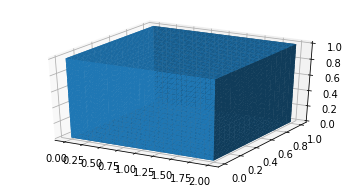

In [ ]:
mesh = BoxMesh(Point(0, 0, 0), Point(2, 1, 1), 32, 16, 16)
# Plotting 3D object may cause error due google colab. In order to not get error
# you should plot it in your computer not in google colab. You can use paraview.
# I know the error I will solve it.
# plot(mesh)

## Defining the finite element function space
When we have created the mesh, we can define the finite element function space. Since we will be solving a system of equations for $u = (u_x, u_y, u_z)$, we create a $P_1$ *vector* function space.

In [ ]:
V = VectorFunctionSpace(mesh, 'P', 1)

## Defining the boundary conditions
The boundary conditions can be defined by specifying all points on the boundary close to either of the two end points $x = 0$ and $x = 2$. Use two `DirichletBC` objects to define the two boundary conditions. Note that the traction boundary condition $g = 0$ is a natural boundary condition and so does not need to be implemented as a Dirichlet boundary condition.

In [ ]:
def left(x, on_boundary):
    return on_boundary and near(x[0], 0.0)

def right(x, on_boundary):
    return on_boundary and near(x[0], 2.0)

u_L = Constant((0, 0, 0))
u_R = Expression(('1.0', '0.5 - x[1] + (x[1] - x[2])/sqrt(2.0)', '0.5 - x[2] + (x[1] + x[2] - 1.0)/sqrt(2.0)'), degree=1) 

bc_L = DirichletBC(V, u_L, left)
bc_R = DirichletBC(V, u_R, right)
bcs = [bc_L, bc_R]

## Defining the variational problem
The finite element variational problem for the hyperelastic problem reads: Find $u \in V$ such that
$$
\int_{\Omega} P(u) : \nabla u \,\mathrm{d}x
=
\int_{\Omega} f \cdot v \,\mathrm{d}x
$$
for all $v \in V$.

This can be expressed in FEniCS by defining the nonlinear form $L$:

\begin{align}
  F(u; v) = \int_{\Omega} P(u) : \nabla u \,\mathrm{d}x
          - \int_{\Omega} f \cdot v \,\mathrm{d}x
\end{align}

and solving $F(u; v) = 0$ for all $v \in V$.

The following expressions can be used to define the first Piola-Kirchoff stress tensor $P$ in FEniCS:

\begin{align}
F &= I + \nabla u \\  
C &= F^{\top}F \\
E &= \frac{1}{2}(C - I) \\
W &= \frac{\lambda}{2}\,\mathrm{tr}(E)^2 + \mu\,\mathrm{tr}(E^2) \\
S &= \frac{\partial W}{\partial E} \\
P &= FS
\end{align}

Note that the derivative $\partial W / \partial E$ can be expressed as `diff(W, E)`, which requires that `E` is wrapped as a `variable` before defining `W`. In other words, define `E = variable(0.5*(C - I))`.

In [ ]:
G = 79300.0
K = 160000.0
mu = Constant(G)
lmbda = Constant(K - 2.0*G/3.0)
f = Constant((0, 0, 0))
d = 3

u = Function(V)
I = Identity(d)
F = I + grad(u)
C = F.T*F
E = variable(0.5*(C - I))
W = 0.5*lmbda*(tr(E)**2) + mu*tr(E*E)
S = diff(W,E)
P = F*S

v = TestFunction(V)
F = inner(P, grad(v))*dx + dot(f, v)*dx

## Solving the variational problem
The variational problem can now be solved by calling the FEniCS `solve` command. Use the `plot` command to visualize the solution. 

In [ ]:
solve(F == 0, u, bcs)
# Plotting 3D object may cause error due google colab. In order to not get error
# you should plot it in your computer not in google colab. You can use paraview.
# I know the error I will solve it. 
# plot(u)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


## Postprocessing
To postprocess the solution using an external postprocessor, for example Paraview, save the solution to VTK format (file suffix `.pvd`).

In [ ]:
File('exercise5/solution_nonlinear.pvd') << u